In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.decomposition import PCA

np.random.seed(40)

In [2]:
# Data Load
df_train = pd.read_csv('train.csv')
df_train = df_train.iloc[:,1:]
df_train.columns = ['hour', 'temp', 'precip',
       'windspeed', 'humidity', 'visibility',
       'ozone', 'pm10', 'pm2_5', 'count']
df_X = df_train[df_train.columns.drop('count')]
df_y = df_train['count'].values

X_train, X_val, y_train, y_val = train_test_split(df_X, df_y, test_size=0.3, random_state=0)

In [3]:
# # Visualize Pipeline
from sklearn import set_config

set_config(display="diagram")

In [4]:
# Data Preprocessing
numeric_features = list(df_X.columns.drop(['precip','hour']))
numeric_transformer = Pipeline(
    steps=[("imputer",SimpleImputer(strategy='median')),("scaler",StandardScaler())]
)
hour_feature = ['hour']
hour_transformer = Pipeline(
    steps=[("imputer",SimpleImputer(strategy='most_frequent')),('scaler',StandardScaler())]
 )
hour_transformer_oh = OneHotEncoder(handle_unknown='ignore',sparse=False) # hour을 onehotencoding으로 처리

categorical_features = ['precip']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ('hour', hour_transformer, hour_feature),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [5]:
# 3 kernel SVR models
svr_rbf = Pipeline(
    steps=[("preprocessor",preprocessor),
    ("svr",SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1))]
)
svr_lin = Pipeline(
    steps=[("preprocessor",preprocessor),
    ("svr",SVR(kernel="linear", C=100, gamma=0.1, epsilon=0.1))]
)
svr_poly = Pipeline(
    steps=[("preprocessor",preprocessor),
    ("svr",SVR(kernel="poly",degree=3 , C=100, gamma=0.1, epsilon=0.1))]
)
models = [svr_rbf,svr_lin,svr_poly]
for svr in models:
    svr.fit(X_train, y_train)


In [6]:
# Metric for each model

for svr in models:
    y_pred = svr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val,y_pred))
    print('Kernel: %s  Score: %.3f' % (svr.named_steps['svr'].kernel, rmse))

Kernel: rbf  Score: 44.902
Kernel: linear  Score: 52.397
Kernel: poly  Score: 48.031


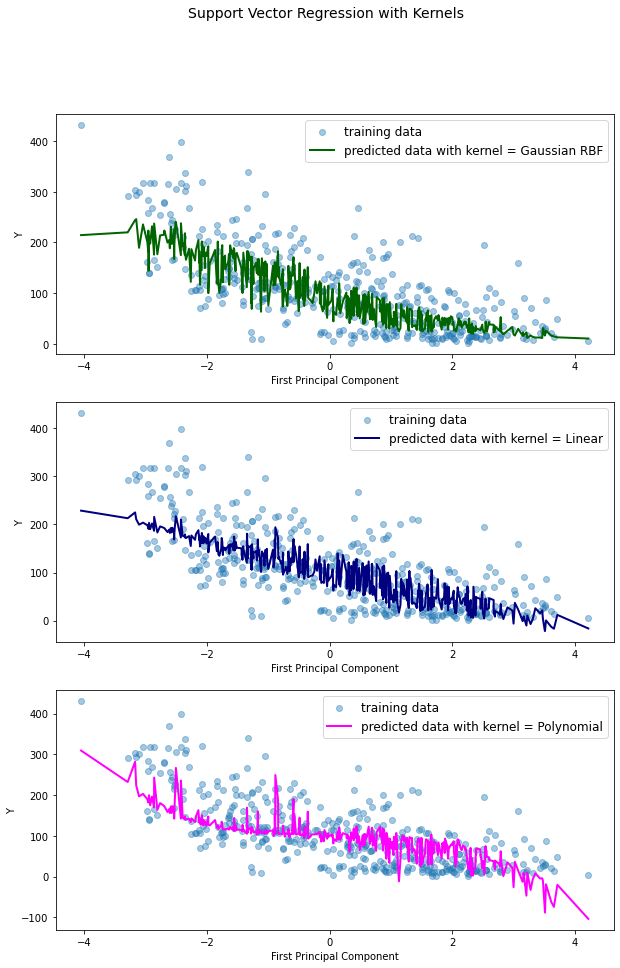

In [7]:
# SVR with PCA and Plot
from sklearn.decomposition import PCA
svr_rbf = Pipeline(
    steps=[("preprocessor",preprocessor),
    ('pca',PCA(n_components=3)),
    ("svr",SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1))]
)
svr_lin = Pipeline(
    steps=[("preprocessor",preprocessor),
    ('pca',PCA(n_components=3)),
    ("svr",SVR(kernel="linear", C=100, gamma=0.1, epsilon=0.1))]
)
svr_poly = Pipeline(
    steps=[("preprocessor",preprocessor),
    ('pca',PCA(n_components=3)),
    ("svr",SVR(kernel="poly",degree=3 , C=100, gamma=0.1, epsilon=0.1))]
)
models = [svr_rbf, svr_lin, svr_poly]
kernel_labels = ['Gaussian RBF','Linear','Polynomial']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (10,15))
cmap = ['darkgreen', 'navy', 'magenta']
for idx, svr in enumerate(models):
    svr.fit(X_train, y_train)
    pca = svr[0:2] # Pipeline until PCA
    xs, ys = zip(*sorted(zip(pca.transform(X_val)[:,0],svr.predict(X_val)))) # projected X and predicted y
    axes[idx].scatter(pca.transform(X_val)[:,0], y_val, alpha = 0.4, label='training data')
    axes[idx].plot(xs, ys, label = 'predicted data with kernel = ' + kernel_labels[idx], color=cmap[idx], linewidth = 2)
    axes[idx].legend(fontsize = 12, loc='upper right')
    axes[idx].set(xlabel = 'First Principal Component', ylabel='Y')

fig.suptitle("Support Vector Regression with Kernels", fontsize = 14)
plt.savefig("plots/SVR_with_PCA_by_kernel.png", facecolor = 'white', transparent = False)




In [8]:
# Hyperparameter Tuning with GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# RMSE def for Gridsearch Scoring
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return(np.sqrt(mse))
rmse_score = make_scorer(rmse, greater_is_better=False)

# Model and grid setting
svr = Pipeline(
    steps=[("preprocessor",preprocessor),("svr",SVR())]
)
param_grid = {
    'svr__C' : np.logspace(-2,2,5), # Regularization
    'svr__kernel' : ['rbf'],
    'svr__epsilon' : np.logspace(-3,0,4), # epsilon at SVM regressor
    'svr__gamma' : ['auto', 0.1, 0.01]
}
svr_grid = GridSearchCV(svr, param_grid, verbose=2, scoring=rmse_score)

In [9]:
svr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END svr__C=0.01, svr__epsilon=0.001, svr__gamma=auto, svr__kernel=rbf; total time=   0.1s
[CV] END svr__C=0.01, svr__epsilon=0.001, svr__gamma=auto, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.01, svr__epsilon=0.001, svr__gamma=auto, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.01, svr__epsilon=0.001, svr__gamma=auto, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.01, svr__epsilon=0.001, svr__gamma=auto, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.01, svr__epsilon=0.001, svr__gamma=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.01, svr__epsilon=0.001, svr__gamma=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.01, svr__epsilon=0.001, svr__gamma=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.01, svr__epsilon=0.001, svr__gamma=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.01, svr__epsilon=0.001, svr__gamma=0.1, svr__kernel=rbf; total time= 

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'windspeed',
                                                                          'humidity',
                                                                          'visibility',
                                                                          'ozone',
                                                                          'pm10',
                                                                          'pm2_5']),
                                                                        ('hour',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['hour']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['precip'])])),
                                       ('svr', SVR())]),
             param_grid={'svr__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'svr__epsilon': array([0.001, 0.01 , 0.1  , 1.   ]),
                         'svr__gamma': ['auto', 0.1, 0.01],
                         'svr__kernel': ['rbf']},
             scoring=make_scorer(rmse, greater_is_better=False), verbose=2)

In [10]:
# Gridsearch result
from copy import deepcopy
best_params = deepcopy(svr_grid.best_params_)
for key in param_grid.keys():
    best_params[key[5:]] = best_params.pop(key)
print(best_params)

{'C': 100.0, 'kernel': 'rbf', 'epsilon': 1.0, 'gamma': 0.1}


In [11]:
# Best SVR model
svr_best = Pipeline(steps=[('preprocessor',preprocessor),('svr',SVR(**best_params))])
svr_best.fit(X_train, y_train)
# Validation RMSE
y_pred = svr_best.predict(X_val)
rmse(y_val, y_pred).round(3) # 44.871

44.871

In [13]:
# NuSVR
from sklearn.svm import NuSVR
nusvr = Pipeline(
    steps=[("preprocessor",preprocessor),("svr",NuSVR())]
)
param_grid = {
    'svr__nu' : [0.01, 0.1, 0.5, 0.75],
    'svr__C' : np.logspace(-2,2,5), # Regularization
    'svr__kernel' : ['rbf','linear'],
    'svr__gamma' : ['auto', 0.1, 0.01]
}
nusvr_grid = GridSearchCV(nusvr, param_grid, verbose=2, scoring=rmse_score)

In [14]:
#Fit
nusvr_grid.fit(X_train,y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END svr__C=0.01, svr__gamma=auto, svr__kernel=rbf, svr__nu=0.01; total time=   0.0s
[CV] END svr__C=0.01, svr__gamma=auto, svr__kernel=rbf, svr__nu=0.01; total time=   0.0s
[CV] END svr__C=0.01, svr__gamma=auto, svr__kernel=rbf, svr__nu=0.01; total time=   0.0s
[CV] END svr__C=0.01, svr__gamma=auto, svr__kernel=rbf, svr__nu=0.01; total time=   0.0s
[CV] END svr__C=0.01, svr__gamma=auto, svr__kernel=rbf, svr__nu=0.01; total time=   0.0s
[CV] END svr__C=0.01, svr__gamma=auto, svr__kernel=rbf, svr__nu=0.1; total time=   0.0s
[CV] END svr__C=0.01, svr__gamma=auto, svr__kernel=rbf, svr__nu=0.1; total time=   0.0s
[CV] END svr__C=0.01, svr__gamma=auto, svr__kernel=rbf, svr__nu=0.1; total time=   0.0s
[CV] END svr__C=0.01, svr__gamma=auto, svr__kernel=rbf, svr__nu=0.1; total time=   0.0s
[CV] END svr__C=0.01, svr__gamma=auto, svr__kernel=rbf, svr__nu=0.1; total time=   0.0s
[CV] END svr__C=0.01, svr__gamma=auto, svr__kernel=r

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'windspeed',
                                                                          'humidity',
                                                                          'visibility',
                                                                          'ozone',
                                                                          'pm10',
                                                                          'pm2_5']),
                                                                        ('hour',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['hour']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['precip'])])),
                                       ('svr', NuSVR())]),
             param_grid={'svr__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'svr__gamma': ['auto', 0.1, 0.01],
                         'svr__kernel': ['rbf', 'linear'],
                         'svr__nu': [0.01, 0.1, 0.5, 0.75]},
             scoring=make_scorer(rmse, greater_is_better=False), verbose=2)

In [15]:
# Gridsearch result
from copy import deepcopy
best_params = deepcopy(nusvr_grid.best_params_)
for key in param_grid.keys():
    best_params[key[5:]] = best_params.pop(key)
print(best_params)

{'nu': 0.5, 'C': 100.0, 'kernel': 'rbf', 'gamma': 0.1}


In [16]:
# Best NuSVR model
nusvr_best = Pipeline(steps=[('preprocessor',preprocessor),('svr',NuSVR(**best_params))])
nusvr_best.fit(X_train, y_train)
# Validation RMSE
y_pred = nusvr_best.predict(X_val)
rmse(y_val, y_pred).round(3) # 43.844

43.844